# Lezione 22

In [ ]:
from liblet import ANTLR, Tree, AnnotatedTreeWalker

from symboltable import SymbolTable

## Un linguaggio con tipi (primitivi)

Consideriamo una variante del linguaggio precedente in cui ci siano due tipi *primitivi*: *interi* e *stringhe* e dove sia consentito solo:

* formare tutte le espressioni binarie con entrambe gli operandi interi,
* confrontare due stringhe, oppure sommare due stringhe (ottenendone la concatenazione), o moltiplicare (in quest'ordine) una stringa per un intero (ottenendone la ripetizione),

Si assuma inoltre che il risultato di un confronto valga `0` se falso e `-1` se vero.

Potete dare una occhiata a Wikipedia per avere una "infarinatura" delle questioni relative ai [Type System](https://en.wikipedia.org/wiki/Type_system).

In [ ]:
SimpleTypedBlockLang = ANTLR(r"""grammar SimpleTypedBlockLang;

program: stat+ ;

block: '{' stat* '}' ;

expr: '!' expr            # notExpr
    | expr '*' expr       # prodExpr
    | expr ('+'|'-') expr # addSubExpr
    | expr '==' expr      # equalityExpr
    | ID                  # varRefExpr
    | INT                 # intExpr
    | STRING              # strExpr
    | '(' expr ')'        # subExpr
    ;

varType: 'int' | 'string' ;

stat: block                                # blockStat
    | varType ID ('=' expr)? ';'           # varDeclStat
    | 'if' expr 'then' stat ('else' stat)? # ifElseStat
    | 'repeat' expr 'times' stat           # repeatStat
    | ID '=' expr ';'                      # assignementStat
    ;

STRING: '"' LETTER* '"' ;
ID: LETTER (LETTER | [0-9])* ;
INT: [0-9]+ ;
WS: [ \t\n\r]+ -> skip ;
fragment
LETTER : [a-zA-Z] ;
""")

In [ ]:
source = r"""
int x;
string y;
if x == "ciao" then {
  string x = "ciao";
  int z = x * 3;
  repeat "due" times
    y = y + 1;
}
"""

### Costruzione dell'AST

La costruzione dell'AST avviene a partire dalla funzione sviluppata in precedenza

In [ ]:
simpleTypedBlock2ast = AnnotatedTreeWalker.load('simpleBlock2ast.atw')

Per prima cosa, la regola `varDeclStat` deve tener conto anche del tipo di variabile, annotato nell'attributo `varType`

In [ ]:
@simpleTypedBlock2ast.register
def varDeclStat(visit, ptree):
  varType = ptree.children[0].children[0].attr.name
  name = ptree.children[1].attr.value
  if len(ptree.children) == 5:
    return Tree({'type': 'varDeclInitStat', 'varName': name, 'varType': varType}, [visit(ptree.children[3])])
  else:
    return Tree({'type': 'varDeclStat', 'varName': name, 'varType': varType})

Infine va trattato il caso del nuovo atomo corrispondete alle stringhe

In [ ]:
@simpleTypedBlock2ast.register
def strExpr(visit, ptree):
  return Tree({'type': 'strExpr', 'value': ptree.children[0].attr.value[1:-1]})

Come esempio, il sorgente di cui sopra

In [ ]:
def src2ast(source):
  return simpleTypedBlock2ast(SimpleTypedBlockLang.tree(source, 'program'))

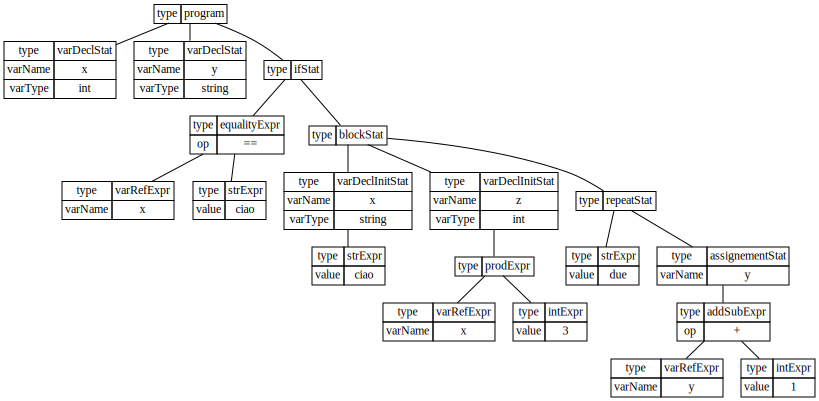

In [ ]:
ast = src2ast(source)
ast

### Decoriamo l'AST con la Symbol Table

Propaghiamo *top-down* il tipo delle variabili dalla loro dichiarazione nel loro *scope*:

In [ ]:
def addTypeST(ast, st):
  if ast.attr.type == 'blockStat': 
    st = SymbolTable(st)
  elif ast.attr.type in {'varDeclStat', 'varDeclInitStat'}:
    st.bind(ast.attr.varName, ast.attr.varType)
  ast.attr._st = st
  for child in ast.children: addTypeST(child, st)

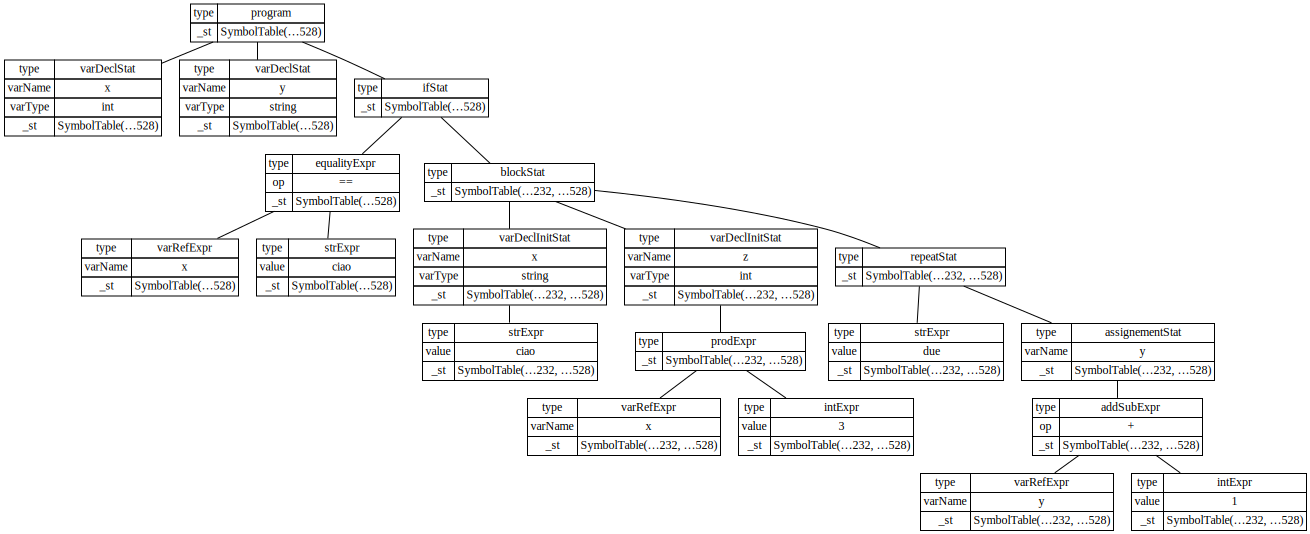

In [ ]:
GLOBAL = SymbolTable()
addTypeST(ast, GLOBAL)
ast

Osserviamo ad esempio cosa accade nel blocco `GLOBAL`

In [ ]:
GLOBAL.symbol2info

{'x': 'int', 'y': 'string'}

### Determinazione del tipo delle espressioni

Ora, in modalità *bottom-up* aggiungiamo a nodo corrispondente ad una espressione il suo tipo, che verrà annotato nell'attributo `_exprType` (per convenzione `None` indica l'impossibilità di determinare il tipo, in questo contesto, a causa di un errore).

In [ ]:
addExprType = AnnotatedTreeWalker('type', AnnotatedTreeWalker.RECOURSE_CHILDREN)

Il caso degli atomi è particolarmente semplice

In [ ]:
@addExprType.register
def intExpr(visit, expr):
  expr.attr._exprType = 'int'

@addExprType.register
def strExpr(visit, expr):
  expr.attr._exprType = 'string'

@addExprType.register
def varRefExpr(visit, expr):
  expr.attr._exprType = expr.attr._st.lookup(expr.attr.varName)

Per le espressioni binarie, basta rifarsi alle definizioni date presentando il linguaggio.

In [ ]:
@addExprType.register
def prodExpr(visit, expr):
  left, right = expr.children
  visit(left)
  visit(right)
  left = left.attr._exprType
  right = right.attr._exprType
  if left == 'int' and right == 'int':
    expr.attr._exprType = 'int'
  elif left == 'string' and right == 'int':
    expr.attr._exprType = 'string'
  else:
    expr.attr._exprType = None

@addExprType.register
def addSubExpr(visit, expr):
  left, right = expr.children
  visit(left)
  visit(right)
  op = expr.attr.op
  left = left.attr._exprType
  right = right.attr._exprType
  if left == 'int' and right == 'int':
    expr.attr._exprType = 'int'
  elif left == 'string' and right == 'string' and op == '+':
    expr.attr._exprType = 'string'
  else:
    expr.attr._exprType = None

@addExprType.register
def equalityExpr(visit, expr):
  left, right = expr.children
  visit(left)
  visit(right)
  left = left.attr._exprType
  right = right.attr._exprType
  if left == right:
    expr.attr._exprType = 'int'
  else:
    expr.attr._exprType = None

Sempre sullo stesso sorgente…

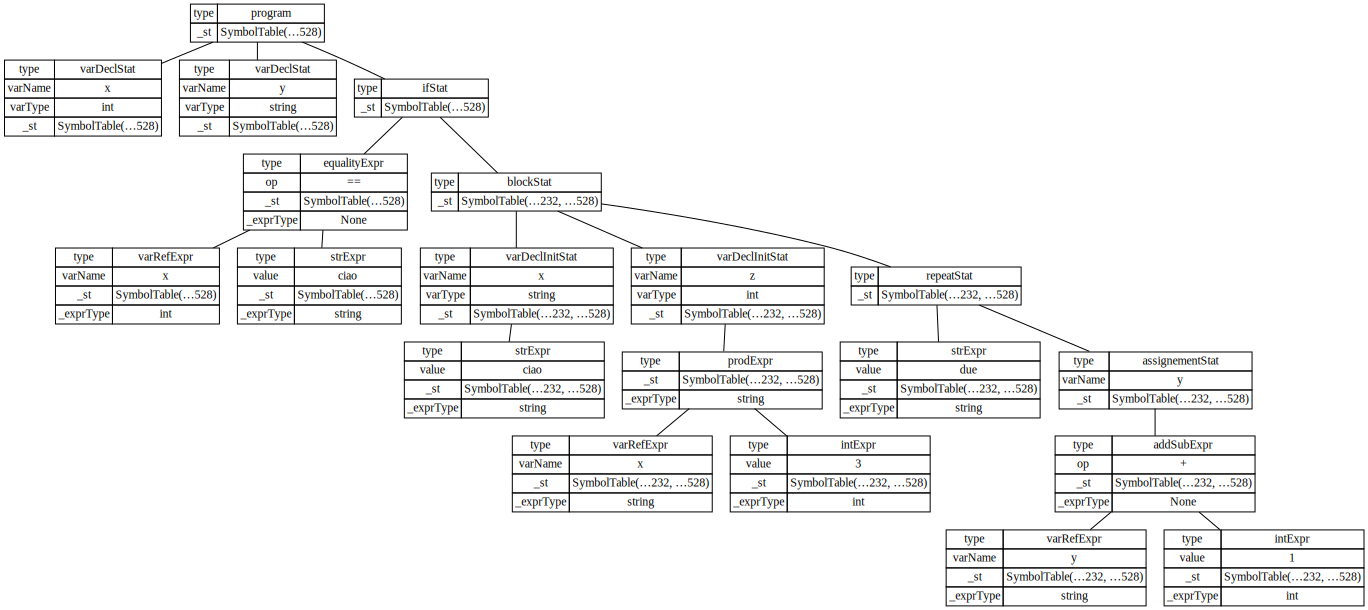

In [ ]:
addExprType(ast)
ast

### Dalle espressioni agli statement

Determinato il tipo delle espressioni, siamo pronti a controllare gli *statement*: 

* la selezione e iterazione devono avere un intero come tipo d'espressione,
* gli assegnamenti (anche in dichiarazione) devono concordare con il tipo della variabile.

In [ ]:
checkType = AnnotatedTreeWalker('type', AnnotatedTreeWalker.RECOURSE_CHILDREN)

In [ ]:
@checkType.register
def repeatStat(visit, stat):
  if stat.children[0].attr._exprType != 'int':
    stat.attr._typeCheck = 'FAIL'
  for child in stat.children: visit(child)
    
@checkType.register
def ifElseStat(visit, stat):
  if stat.children[0].attr._exprType != 'int':
    stat.attr._typeCheck = 'FAIL'
  for child in stat.children: visit(child)

@checkType.register
def varDeclInitStat(visit, stat):
  if stat.children[0].attr._exprType != stat.attr.varType:
    stat.attr._typeCheck = 'FAIL'

@checkType.register
def assignementStat(visit, stat):
  if stat.children[0].attr._exprType != stat.attr._st.lookup(stat.attr.varName):
    stat.attr._typeCheck = 'FAIL'  

Facciamo un altro passo sull'AST

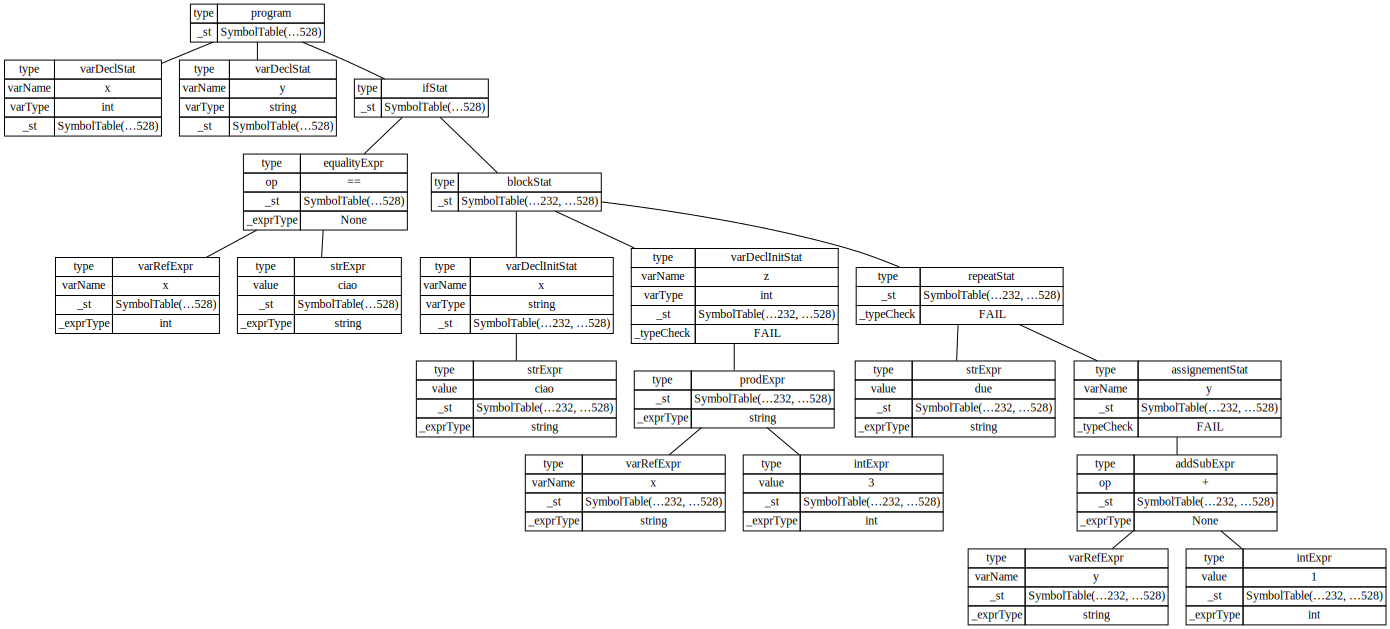

In [ ]:
checkType(ast)
ast

#### Emettere degli errori…

Emettere errori "sensati" è difficile… qui ci limitiamo a visitare l'AST e stampare i nodi per cui o l'espressione, o lo statement, non siano corrette dal punto di vista dei tipi.

In [ ]:
def report(ast):
  try:
    if ast.attr._typeCheck == 'FAIL': print(ast.root)
  except KeyError:
    pass
  try:
    if ast.attr._exprType is None: print(ast.root)
  except KeyError:
    pass
  for child in ast.children: report(child)

Un ultimo giro sull'AST

In [ ]:
report(ast)

{'type': 'equalityExpr', 'op': '==', '_st': SymbolTable(…528), '_exprType': None}
{'type': 'varDeclInitStat', 'varName': 'z', 'varType': 'int', '_st': SymbolTable(…232, …528), '_typeCheck': 'FAIL'}
{'type': 'repeatStat', '_st': SymbolTable(…232, …528), '_typeCheck': 'FAIL'}
{'type': 'assignementStat', 'varName': 'y', '_st': SymbolTable(…232, …528), '_typeCheck': 'FAIL'}
{'type': 'addSubExpr', 'op': '+', '_st': SymbolTable(…232, …528), '_exprType': None}
